In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings

from flow_utils import *

In [2]:
warnings.filterwarnings("ignore")

## Read Data

In [3]:
data_path='../data/'
file='climateai_coding_challenge_data_v2.nc'
ds=xr.open_dataset(data_path+file)
ds

<xarray.Dataset>
Dimensions:         (station_number: 9, time_flow: 21542, time_weather: 21546)
Coordinates:
  * time_flow       (time_flow) datetime64[ns] 1958-01-04 ... 2016-12-26
  * time_weather    (time_weather) datetime64[ns] 1957-01-01 ... 2015-12-31
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 ...
    lon             float64 ...
Data variables:
    flow            (time_flow) float64 ...
    temperature     (time_weather, station_number) float64 ...
    precipitation   (time_weather, station_number) float64 ...

### Extract Dates to Match for features and target

In [4]:
# Features
ds_trunc_precip=ds['precipitation'].sel(time_weather=slice('1958-01-04','2015-12-24'))
ds_trunc_temp=ds['temperature'].sel(time_weather=slice('1958-01-04','2015-12-24'))
ds_trunc_flowf=ds['flow'].sel(time_flow=slice('1958-01-04','2015-12-24'))

# Target
ds_trunc_flow=ds['flow'].sel(time_flow=slice('1958-01-11','2015-12-31'))

### Check Dimensions of Data

In [5]:
print(ds_trunc_precip)
print(ds_trunc_temp)
print(ds_trunc_flowf)
print(ds_trunc_flow)

<xarray.DataArray 'precipitation' (time_weather: 21171, station_number: 9)>
[190539 values with dtype=float64]
Coordinates:
  * time_weather    (time_weather) datetime64[ns] 1958-01-04 ... 2015-12-24
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 60.23
    lon             float64 9.37
<xarray.DataArray 'temperature' (time_weather: 21171, station_number: 9)>
[190539 values with dtype=float64]
Coordinates:
  * time_weather    (time_weather) datetime64[ns] 1958-01-04 ... 2015-12-24
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 60.23
    lon             float64 9.37
<xarray.DataArray 'flow' (time_flow: 21174)>
array([1.723781e+00, 9.608816e-01, 1.000000e-03, ..., 2.309434e+00,
       4.281342e+00, 3.734578e+00])
Coordinates:
  * time_flow  (time_flow) datetime64[ns] 1958-01-04 1958-01-05 ... 2015-12-24
    lat        float64 60.23
    lon        float64 9.37
<xarray.DataArray 'flow' (time_flow: 21174)>
arr

### Quick Look at data 

Text(0.5, 1.0, 'River Flow')

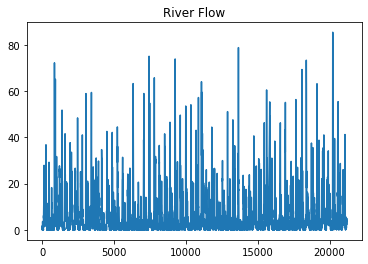

In [6]:
plt.plot(ds_trunc_flow)
plt.title('River Flow')

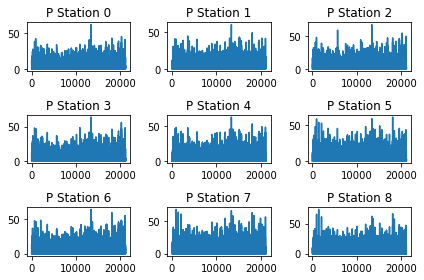

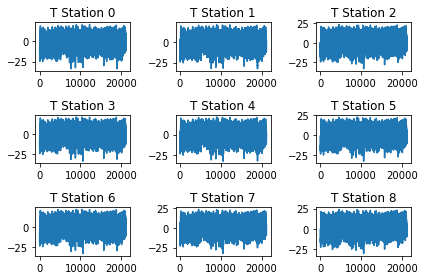

In [7]:
ncols=3
nrows=3

fig = plt.figure()
for i,station in enumerate(ds['station_number']):
    plt.subplot(nrows,ncols,i+1)
    plt.plot(ds_trunc_precip.sel(station_number=station))
    plt.title('P Station '+str(i))
plt.tight_layout()
    
fig = plt.figure()
for i,station in enumerate(ds['station_number']):
    plt.subplot(nrows,ncols,i+1)
    plt.plot(ds_trunc_temp.sel(station_number=station))
    plt.title('T Station '+str(i))
plt.tight_layout()

## Define Features and Targets and put into `numpy` array 
Features (`X`): precipitation, temperature, flow

Target (`Y`): flow one week later

In [8]:
ds_trunc_flowf=ds_trunc_flowf.where(ds_trunc_flowf['time_flow'].isin(ds_trunc_precip['time_weather']), drop=True)
X=np.concatenate((ds_trunc_precip.values,ds_trunc_temp.values,np.expand_dims(ds_trunc_flowf.values,1)),axis=1)
Y=ds_trunc_flow.where(ds_trunc_flow['time_flow'].isin(ds_trunc_precip['time_weather']+pd.Timedelta(days=7)), drop=True).values

In [9]:
print('Check Features and Target Dimensions')
print('Features (X): ',X.shape)
print('Target (Y): ',Y.shape)

nsamples=X.shape[0]
nfeatures=X.shape[1]

print("Samples: ",nsamples)
print("features: ", nfeatures)

Check Features and Target Dimensions
Features (X):  (21171, 19)
Target (Y):  (21171,)
Samples:  21171
features:  19


### Split Data into Training and Test

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

print('Training Size: ',ntrain)
print('Testing Size: ',ntest)

Training Size:  16936
Testing Size:  4235


### Quick look at subset of training data

Text(0.5, 1.0, 'Flow')

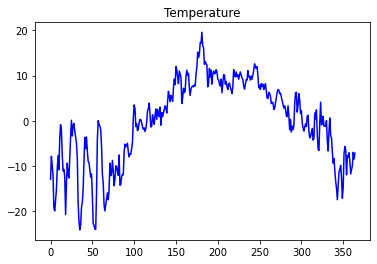

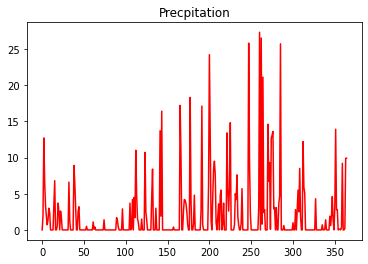

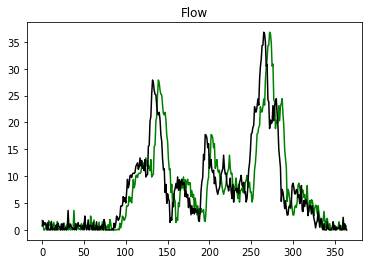

In [11]:
fig = plt.figure()
plt.plot(X_train[0:365,10],'b')
plt.title('Temperature')

fig = plt.figure()
plt.plot(X_train[0:365,0],'r')
plt.title('Precpitation')

fig = plt.figure()
plt.plot(X_train[0:365,18],'g')
plt.plot(Y_train[0:365],'k')
plt.title('Flow')

### Take a look at training data & Relationships between variables

#### Mean, Variance, Trend

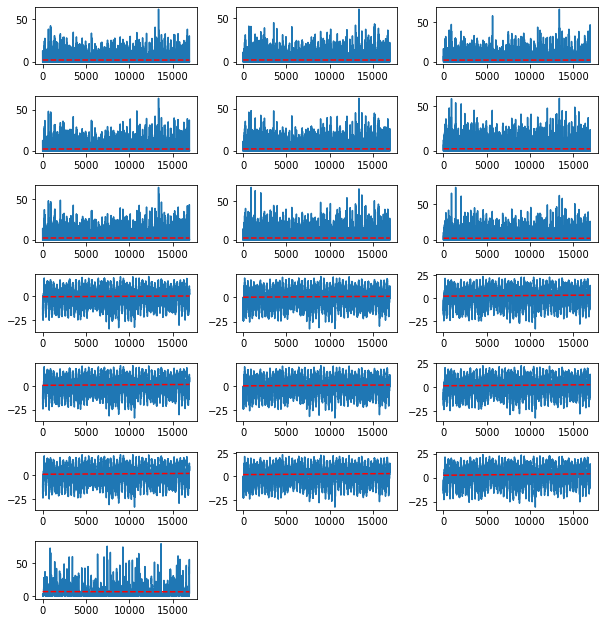

In [12]:
plt.figure(figsize=(8.5,11))
y=np.arange(ntrain)

for i in range(nfeatures):

    plt.subplot(9,3,i+1)

    z = np.polyfit(y,X_train[:,i],1)
    p = np.poly1d(z)
    plt.plot(y,X_train[:,i])
    plt.plot(p(y),"r--")
plt.tight_layout()    
    #print("Check Stats: ", "Station: ",i, "Mean: ", X_train[:,i].mean(axis=0),"Var: ", X_train[:,i].var(axis=0))
    

### Summary
* Trend in temperature, but not precipitation
* Data will need to be standardized

#### How correlated are all the features and target with each other?

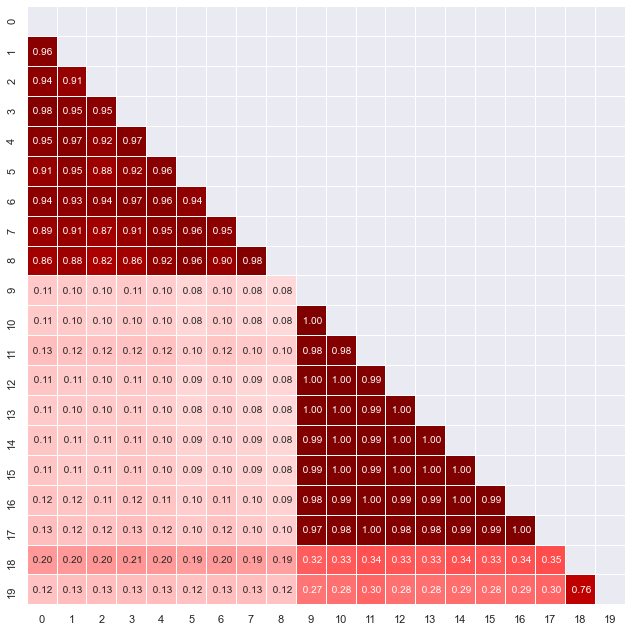

In [13]:
heatmap(X_train,Y_train)

### Summary
* Temperature stations highly correlated with each other
* Precipitation stations highly correlated with each other
* High correlation between features means that there is not a lot of independent information in each of the features; will need regularization to avoid overfitting
* Precipitation is weakly correlated with flow one week later
* Flow is highly correlated with itself one week later, so is likely to be the best predictor of future flow

### Seasonal Cycle & Anomalies

#### Create an `xarray.Dataset` of training data

In [14]:
ds_tmp1=xr.DataArray(X_train[:,0:9],
                    coords={'time':ds_trunc_precip['time_weather'][0:ntrain].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='precipitation')
ds_tmp2=xr.DataArray(X_train[:,9:18],
                    coords={'time':ds_trunc_precip['time_weather'][0:ntrain].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='temperature')

ds_tmp3=xr.DataArray(np.expand_dims(X_train[:,18],axis=1),
                    coords={'time':ds_trunc_precip['time_weather'][0:ntrain,].values,
                           'stations':np.arange(1)},
                    dims=['time','stations']).to_dataset(name='flow')

ds_Xtrain=xr.merge([ds_tmp1,ds_tmp2,ds_tmp3])


ds_Ytrain=xr.DataArray(Y_train[:],
                    coords={'time':ds_trunc_flow['time_flow'][0:ntrain].values},
                    dims=['time']).to_dataset(name='flow')

### Calculate climatology and anomalies

In [15]:
precip_climo=daily_climo(ds_Xtrain,'precipitation','feature')
temp_climo=daily_climo(ds_Xtrain,'temperature','feature')
flowf_climo=daily_climo(ds_Xtrain,'flow','feature')

climo_Xtrain=xr.merge([precip_climo,temp_climo,flowf_climo])
climo_Ytrain=daily_climo(ds_Ytrain,'flow','target').to_dataset(name='flow')

ds_anoms_Xtrain=ds_Xtrain.groupby('time.dayofyear')-climo_Xtrain
ds_anoms_Ytrain=ds_Ytrain.groupby('time.dayofyear')-climo_Ytrain

### Plot the Climatology for the temperature and precip stations

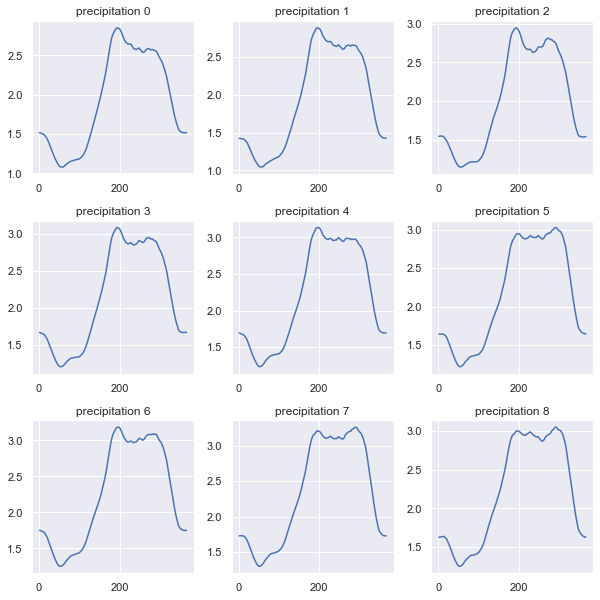

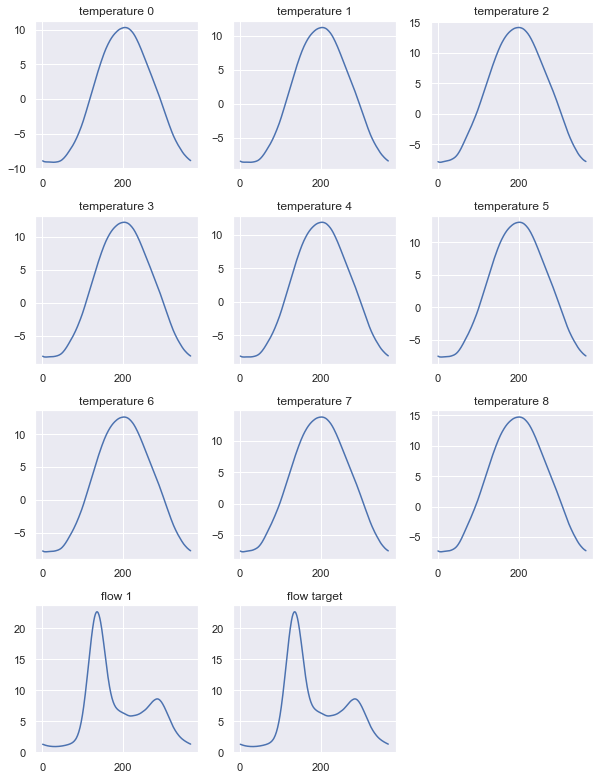

In [16]:
# Temperature and Precipitation
for v in ['precipitation','temperature']:
    plt.figure(figsize=(8.5,11))
    for i in range(9):

        plt.subplot(4,3,i+1)
        plt.plot(climo_Xtrain['dayofyear'],climo_Xtrain[v][:,i])
        plt.title(v+' '+str(i))
        
    i=i+1 
    plt.tight_layout()
    
# Flow
plt.subplot(4,3,i+1)
plt.plot(climo_Xtrain['dayofyear'],climo_Xtrain['flow'][:,0])
plt.title('flow 1')
plt.tight_layout()
  
# Target Flow   
i=i+1
plt.subplot(4,3,i+1)
plt.plot(climo_Xtrain['dayofyear'],climo_Xtrain['flow'][:,0])
plt.title('flow target')
plt.tight_layout()

### Standardize the Data

In [19]:
ds_anoms_Xtrain_scaled=standardize(ds_anoms_Xtrain)
ds_anoms_Ytrain_scaled=standardize(ds_anoms_Ytrain)

### Convert to `numpy` arrays with correct dimensions for models

In [20]:
Xtrain_scaled=np.concatenate((ds_anoms_Xtrain_scaled['precipitation'].values,
                              ds_anoms_Xtrain_scaled['temperature'].values,
                              np.expand_dims(ds_anoms_Xtrain_scaled['flow'][:,0].values,axis=1)),axis=1)
Ytrain_scaled=ds_anoms_Ytrain_scaled['flow'].values

print('Features Shape: ',Xtrain_scaled.shape)
print('Target Shape: ',Ytrain_scaled.shape)

Features Shape:  (16936, 19)
Target Shape:  (16936,)


### Plot Heatmap

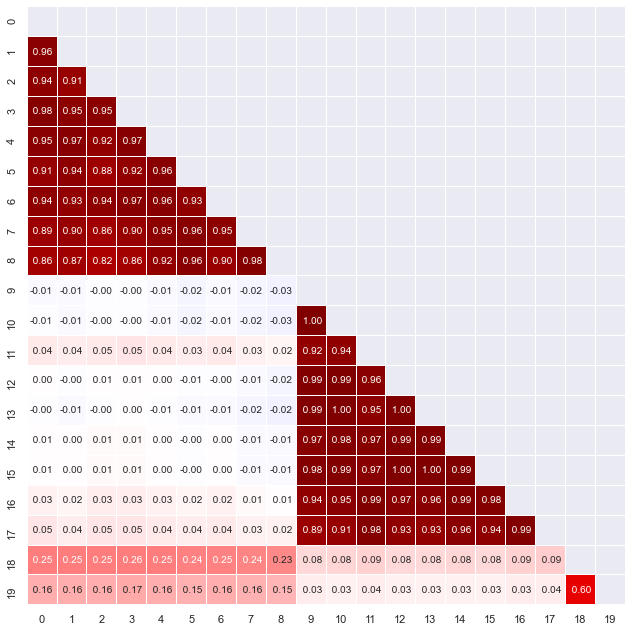

In [21]:
heatmap(Xtrain_scaled,Ytrain_scaled)

### Train Models

In [22]:
regr_lr,coeffs_lr,rsq_train_lr,Ypred_lr=lr(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Standard : ', rsq_train_lr)
regr_lasso,coeffs_lasso,rsq_train_lasso,Ypred_lasso=lasso(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train LASSO : ', rsq_train_lasso)
regr_ridge,coeffs_ridge,rsq_train_ridge,Ypred_ridge=ridge(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Ridge : ', rsq_train_ridge)
nn=tomsensomodel_regression(Xtrain_scaled,Ytrain_scaled)
rsq_train_nn,Y_pred_train_nn=get_r2(Xtrain_scaled,Ytrain_scaled,nn)
print('R^2 Train NN: ',rsq_train_nn)

R^2 Train Standard :  0.6005984394877648
R^2 Train LASSO :  0.600041679043324
R^2 Train Ridge :  0.6004717294068311
R^2 Train NN:  0.6055317724281658


### Test models to see if they generalize

#### Make Forecast by Adding predicted anomalies to climatology

#### Create `xarray.Dataset` of test data

In [23]:
ds_tmp1=xr.DataArray(X_test[:,0:9],
                    coords={'time':ds_trunc_precip['time_weather'][ntrain:ntrain+ntest].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='precipitation')
ds_tmp2=xr.DataArray(X_test[:,9:18],
                    coords={'time':ds_trunc_precip['time_weather'][ntrain:ntrain+ntest].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='temperature')

ds_tmp3=xr.DataArray(np.expand_dims(X_test[:,18],axis=1),
                    coords={'time':ds_trunc_precip['time_weather'][ntrain:ntrain+ntest].values,
                           'stations':np.arange(1)},
                    dims=['time','stations']).to_dataset(name='flow')

ds_Xtest=xr.merge([ds_tmp1,ds_tmp2,ds_tmp3])


ds_Ytest=xr.DataArray(Y_test[:],
                    coords={'time':ds_trunc_flow['time_flow'][ntrain:ntrain+ntest].values},
                    dims=['time']).to_dataset(name='flow')

#### Calculate Anomalies for Test Data

In [24]:
ds_anoms_Xtest=ds_Xtest.groupby('time.dayofyear')-climo_Xtrain
ds_anoms_Ytest=ds_Ytest.groupby('time.dayofyear')-climo_Ytrain

#### Standardize the Data

In [25]:
ds_anoms_Xtest_scaled=(ds_anoms_Xtest-ds_anoms_Xtrain.mean(dim='time'))/ds_anoms_Xtrain.std(dim='time')
ds_anoms_Ytest_scaled=(ds_anoms_Ytest-ds_anoms_Ytrain.mean(dim='time'))/ds_anoms_Ytrain.std(dim='time')

#### Convert to `numpy` arrays with correct dimensions for models

In [26]:
Xtest_scaled=np.concatenate((ds_anoms_Xtest_scaled['precipitation'].values,
                              ds_anoms_Xtest_scaled['temperature'].values,
                              np.expand_dims(ds_anoms_Xtest_scaled['flow'][:,0].values,axis=1)),axis=1)
Ytest_scaled=ds_anoms_Ytest_scaled['flow'].values

print('Features Shape: ',Xtest_scaled.shape)
print('Target Shape: ',Ytest_scaled.shape)

Features Shape:  (4235, 19)
Target Shape:  (4235,)


#### Predict for Test Data

In [27]:
rsq_test_lr,Y_pred_test_lr=get_r2(Xtest_scaled,Ytest_scaled,regr_lr)
print('R^2 Test Standard: ',rsq_test_lr)

rsq_test_lasso,Y_pred_test_lasso=get_r2(Xtest_scaled,Ytest_scaled,regr_lasso)
print('R^2 Test Lasso: ',rsq_test_lasso)

rsq_test_ridge,Y_pred_test_ridge=get_r2(Xtest_scaled,Ytest_scaled,regr_ridge)
print('R^2 Test Ridge: ',rsq_test_lr)

rsq_test_nn,Y_pred_test_nn=get_r2(Xtest_scaled,Ytest_scaled,nn)
print('R^2 Test NN: ',rsq_test_nn)

R^2 Test Standard:  0.586198149896134
R^2 Test Lasso:  0.5865321869872563
R^2 Test Ridge:  0.586198149896134
R^2 Test NN:  0.5902885989301477


In [38]:
mu=ds_anoms_Ytrain['flow'].mean(dim='time').values
sigma=ds_anoms_Ytrain['flow'].std(dim='time').values

flow_lr=(Y_pred_test_lr*sigma+mu)
flow_lasso=(Y_pred_test_lasso*sigma+mu)
flow_nn=(Y_pred_test_nn*sigma+mu)


ds_flow_lr=xr.DataArray(flow_lr,
                        coords={'time':ds_anoms_Ytest['time'].values},
                        dims=['time']).to_dataset(name='standard')
ds_flow_nn=xr.DataArray(flow_nn,
                        coords={'time':ds_anoms_Ytest['time'].values},
                        dims=['time']).to_dataset(name='nn')
ds_flow_lasso=xr.DataArray(flow_lasso,
                           coords={'time':ds_anoms_Ytest['time'].values},
                           dims=['time']).to_dataset(name='lasso')

ds_flow_lr=ds_flow_lr.groupby('time.dayofyear')+climo_Ytrain.rename({'flow':'standard'})
ds_flow_nn=ds_flow_nn.groupby('time.dayofyear')+climo_Ytrain.rename({'flow':'nn'})
ds_flow_lasso=ds_flow_lasso.groupby('time.dayofyear')+climo_Ytrain.rename({'flow':'lasso'})

### Plot the prediction of Test Data

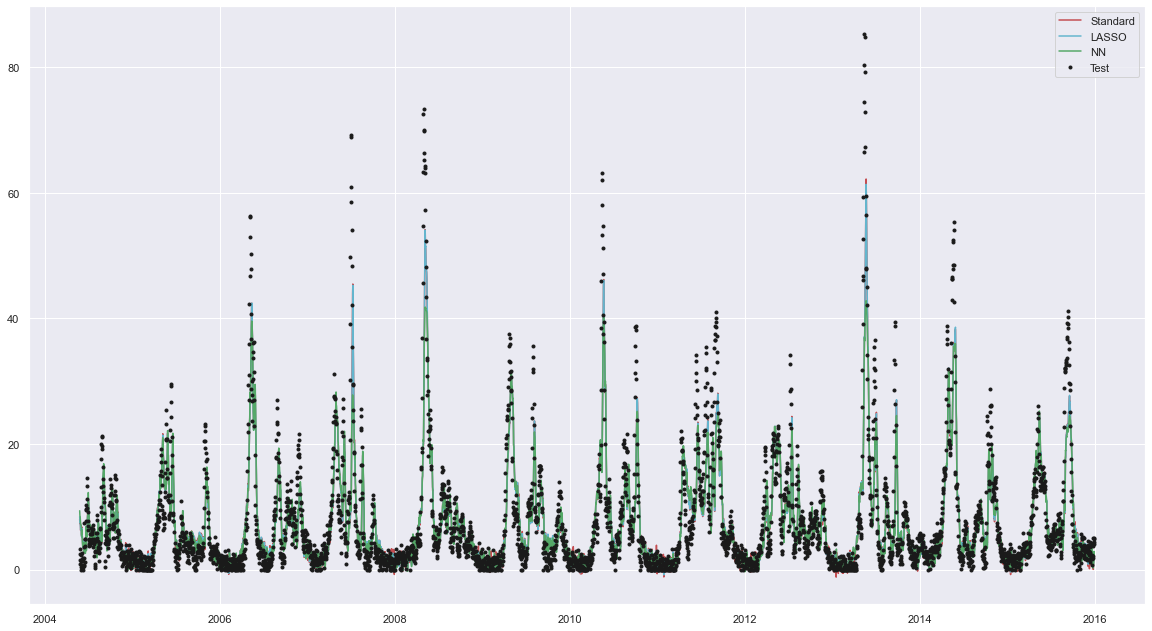

In [46]:
plt.figure(figsize=(20,11))
plt.plot(ds_anoms_Ytest['time'],ds_flow_lr['standard'],'r')
plt.plot(ds_anoms_Ytest['time'],ds_flow_lasso['lasso'],'c')
plt.plot(ds_anoms_Ytest['time'],ds_flow_nn['nn'],'g')
plt.plot(ds_anoms_Ytest['time'],Y_test,'k.')
plt.legend(['Standard','LASSO','NN','Test'])

### Next Steps

*Model*

1. I tried using the average temperature anomaly over a week and the total precipitation anomaly over the week as features, but that made the models worse.  This was suprising to me, so I would want to look into it in more detail. Could also try including time lagged data without any summing or averaging.
2. Since the temperature impact on flow is seasonal, could try fitting separate models for separate seasons rather than for all year.
3. Also, since temperature impact on flow is a threshold, could try full fields instead of anomalies and/or Tmax, Tmin
4. Could try a more sophisticated model, but not expecting significant improvement since the linear relationship with prior flow is so strong this will likely dominate.
5. Explore underprediction in test set. Is there any clear commonality (e.g., season, ??)
6. Perhaps try a different metric such as MSE instead of $r^{2}$

*Code*
1. Better modularization